In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from aum import DatasetWithIndex

import sys
sys.path.insert(0, "../")


/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from data_iq.dataiq_class import *
from src.models.neuralnets import *
from src.utils.data_loader import *
from src.utils.utils import *


## Train base model and log training dynamics w/ Data-IQ

In [3]:
dataset = "covid"
(
    train_loader,
    train_data,
    X_train,
    y_train,
    X_test,
    y_test,
    X_train_pd,
    y_train_pd,
    X_test_pd,
    y_test_pd,
    nlabels,
    corr_vals,
    column_ids,
    df,
) = load_dataset(dataset)

n_feats = X_train.shape[1]

LEARNING_RATE = 0.001
EPOCHS = 20

dataiq_list = []
checkpoint_list = []
ckpt_nets = []
losses = []
val_losses = []

train_loader = DataLoader(
    dataset=DatasetWithIndex(train_data), batch_size=128, shuffle=True
)

net = Net1(input_size=n_feats)
net.to(device)

criterion = torch.nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)


# Instantiate Data-IQ
dataiq = DataIQ_Torch(X=X_train, y=y_train, sparse_labels=True)
dataiq.on_epoch_end(net, device=device)
dataiq_list.append(dataiq)

# Train Model
for e in range(1, EPOCHS + 1):
    net.train()
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch, sample_ids in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        sf = nn.LogSoftmax()
        y_pred = net(X_batch)

        _, predicted = torch.max(y_pred.data, 1)

        y_batch = y_batch.to(torch.int64)

        loss = criterion(sf(y_pred), y_batch)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += (predicted == y_batch).sum().item() / len(y_batch)

    # Log Data-IQ
    dataiq.on_epoch_end(net, device=device)
    print(
        f"Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}"
    )
    ckpt_nets.append(deepcopy(net))
    losses.append(epoch_loss / len(train_loader))
    dataiq_list.append(deepcopy(dataiq))

checkpoint_list.append(ckpt_nets)


/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
../src/models/neuralnets.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = F.softmax(self.output(X))
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 001: | Loss: 0.69185 | Acc: 0.584
Epoch 002: | Loss: 0.68239 | Acc: 0.628
Epoch 003: | Loss: 0.66560 | Acc: 0.666
Epoch 004: | Loss: 0.62279 | Acc: 0.703
Epoch 005: | Loss: 0.58504 | Acc: 0.715
Epoch 006: | Loss: 0.57868 | Acc: 0.719
Epoch 007: | Loss: 0.57144 | Acc: 0.727
Epoch 008: | Loss: 0.56801 | Acc: 0.725
Epoch 009: | Loss: 0.56373 | Acc: 0.735
Epoch 010: | Loss: 0.56521 | Acc: 0.731
Epoch 011: | Loss: 0.56217 | Acc: 0.735
Epoch 012: | Loss: 0.56329 | Acc: 0.734
Epoch 013: | Loss: 0.56248 | Acc: 0.736
Epoch 014: | Loss: 0.56105 | Acc: 0.738
Epoch 015: | Loss: 0.55975 | Acc: 0.741
Epoch 016: | Loss: 0.56454 | Acc: 0.729
Epoch 017: | Loss: 0.56287 | Acc: 0.733
Epoch 018: | Loss: 0.56093 | Acc: 0.737
Epoch 019: | Loss: 0.56141 | Acc: 0.737
Epoch 020: | Loss: 0.56029 | Acc: 0.739


In [4]:
# get the gold label probas
probas = dataiq_list[len(dataiq_list) - 1].gold_labels_probabilities

# get the variance of the probas
var = np.std(probas, axis=0)


# Helpers to compute metrics

In [5]:
def get_confidence(idx):
    conf_sc = []

    for epoch in range(20):

        probs = probas[:, 0 : epoch + 1]

        var = np.mean(probs * (1 - probs), axis=-1)
        var = np.std(probs, axis=-1)

        conf = np.mean(probs, axis=-1)
        conf_sc.append(conf[idx])
    return conf_sc


def get_epistemic(idx):
    epi = []

    for epoch in range(20):

        probs = probas[:, 0 : epoch + 1]
        var = np.mean(probs * (1 - probs), axis=-1)
        var = np.std(probs, axis=-1)
        epi.append(var[idx])
    return epi


def get_aleatoric(idx):
    alea = []

    for epoch in range(20):
        probs = probas[:, 0 : epoch + 1]
        var = np.mean(probs * (1 - probs), axis=-1)
        alea.append(var[idx])
    return alea


## Extract subgroups

In [6]:
d_idx = 20
aleatoric_train = dataiq_list[d_idx].aleatoric
confidence_train = dataiq_list[d_idx].confidence
gold_probas = dataiq_list[d_idx].gold_labels_probabilities
true_probas = dataiq_list[d_idx].true_probabilities

conf_thresh_high = 0.75
conf_thresh_low = 0.25
percentile_thresh = 50

hard_train = np.where(
    (confidence_train <= conf_thresh_low)
    & (aleatoric_train <= np.percentile(aleatoric_train, percentile_thresh))
)[0]
easy_train = np.where(
    (confidence_train >= conf_thresh_high)
    & (aleatoric_train <= np.percentile(aleatoric_train, percentile_thresh))
)[0]

hard_easy = np.concatenate((hard_train, easy_train))
ambig_train = []
for id in range(len(confidence_train)):
    if id not in hard_easy:
        ambig_train.append(id)
ambig_train = np.array(ambig_train)


## Assess how aleatoric uncertainty changes & compared to the distribution

In [7]:
n = 100

groups = ["EASY", "AMBIGUOUS"]
group_dists = []

for group_type in groups:

    if group_type == "EASY":
        group = easy_train
        ids = random.sample(list(group), n)
        to_check = np.argsort(dataiq_list[20].aleatoric[group])[::-1][-n:]
    else:
        group = ambig_train
        ids = random.sample(list(group), n)
        to_check = np.argsort(dataiq_list[20].aleatoric[group])[-n:]

    sample_dists = []

    ids = group[to_check]
    plt.figure()
    for id in ids:
        metric = get_aleatoric(id)
        plt.plot(metric)
        sample_dists.append(metric)

    plt.title(f"{group_type}: Training dynamic aleatoric uncertainty")
    plt.ylim(0, 0.25)
    plt.legend()
    plt.ylabel("Aleatoric Uncertainty")
    plt.ylim(0, 0.3)

    plt.figure()

    for dist in sample_dists:
        sns.distplot(dist)
    plt.xlabel("Aleatoric Uncertainty")
    plt.xlim(0, 0.3)
    plt.title(f"{group_type}: Distribution of aleatoric uncertainty")
    group_dists.append(sample_dists)


No handles with labels found to put in legend.
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distpl

/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be remove

/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be remove

/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be remove

/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be remove

/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be remove

/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be remove

# Compare the effect of averaging across two groups: even with averaging they are different

/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


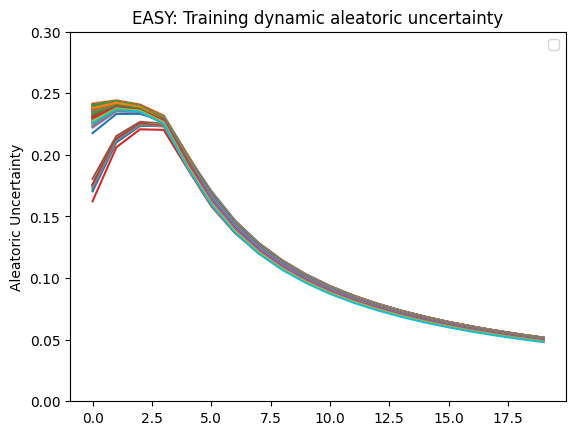

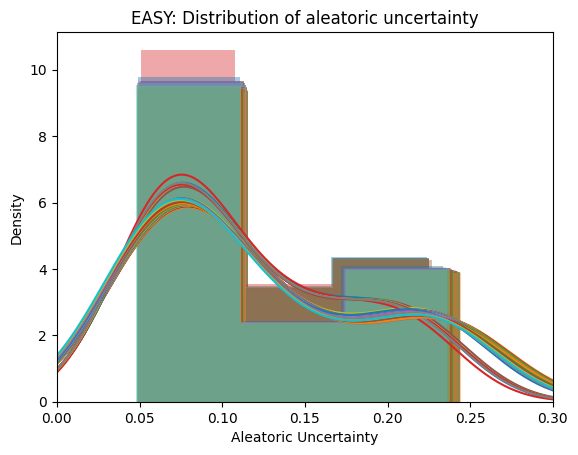

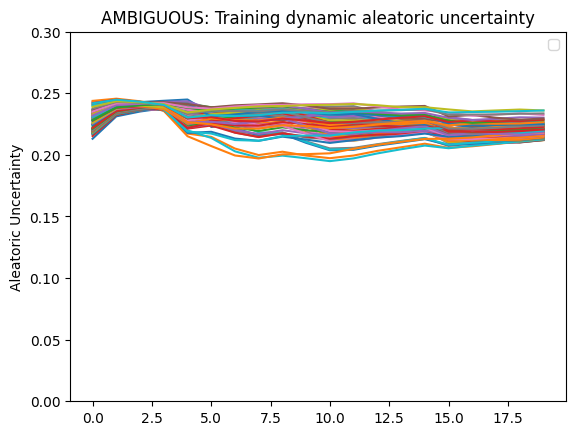

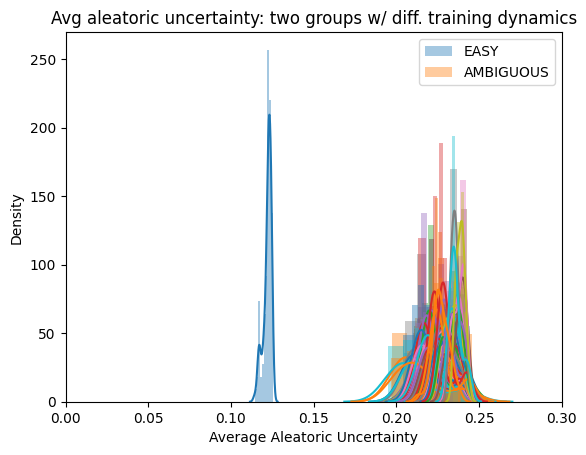

In [8]:
sns.distplot(np.mean(np.array(group_dists[0]), axis=1), label="EASY")
sns.distplot(np.mean(np.array(group_dists[1]), axis=1), label="AMBIGUOUS")
plt.xlabel("Average Aleatoric Uncertainty")
plt.legend()
plt.title("Avg aleatoric uncertainty: two groups w/ diff. training dynamics")
plt.show()


# Analyze the confidence metric as well

No handles with labels found to put in legend.
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distpl

/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be remove

/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be remove

/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nabeel/Documents/Projects/Subsets/camera_code/dataiq_env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be remove

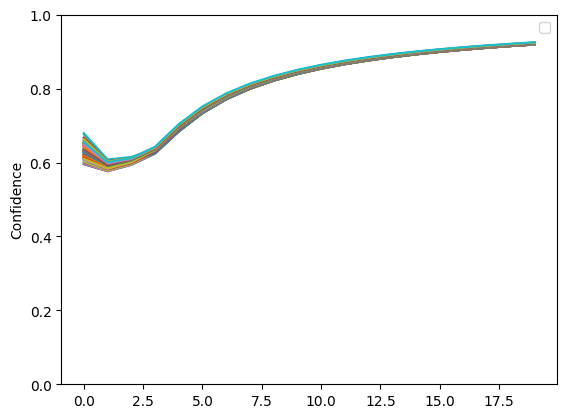

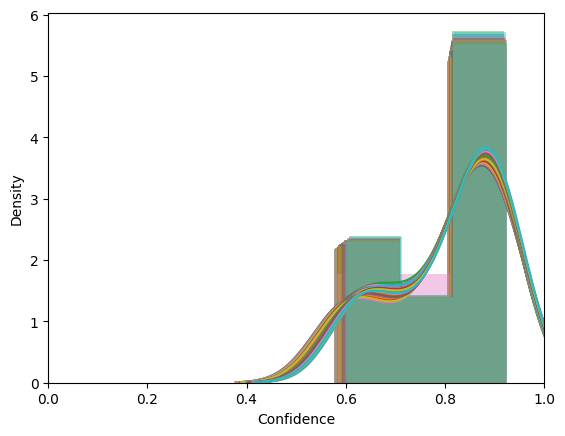

In [9]:
n = 100
group = easy_train

sample_dists = []

ids = random.sample(list(group), n)
to_check = np.argsort(dataiq_list[20].confidence[group])[-n:]
ids = group[to_check]
plt.figure()
for id in ids:
    metric = get_confidence(id)
    plt.plot(metric)
    sample_dists.append(metric)

plt.ylim(0, 1)
plt.legend()
plt.ylabel("Confidence")


plt.figure()

for dist in sample_dists:
    sns.distplot(dist)
plt.xlabel("Confidence")
plt.xlim(0, 1)

plt.show()
